In [39]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split, GridSearchCV, cross_val_score,\
KFold, LeaveOneOut, StratifiedKFold,ParameterGrid

from sklearn.metrics import mean_squared_error, ConfusionMatrixDisplay, confusion_matrix,\
    mean_absolute_error,plot_roc_curve, r2_score, f1_score, \
    accuracy_score,auc, roc_auc_score, roc_curve, RocCurveDisplay,\
    recall_score,precision_score
from sklearn import preprocessing
from sklearn.ensemble import RandomForestClassifier
from sklearn.preprocessing import MinMaxScaler, StandardScaler
import time

import imblearn

from imblearn.over_sampling import SMOTE
import imblearn.pipeline as imb_pipeline

import sklearn

from collections import Counter
from sklearn.svm import SVR, SVC
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import AdaBoostClassifier, GradientBoostingClassifier, RandomForestRegressor
import xgboost as xgb
from sklearn.model_selection import cross_val_score,StratifiedKFold
from sklearn.decomposition import TruncatedSVD, PCA
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import OneHotEncoder, PolynomialFeatures
from sklearn.metrics import r2_score, mean_squared_error
from sklearn.linear_model import LinearRegression, Ridge, Lasso
from sklearn.cross_decomposition import PLSRegression
from sklearn.base import TransformerMixin, BaseEstimator
from sklearn.feature_selection import f_regression, SelectKBest, VarianceThreshold, SelectFromModel
from sklearn.neural_network import MLPRegressor
from sklearn.neighbors import KNeighborsRegressor
from sklearn.ensemble import GradientBoostingRegressor, AdaBoostRegressor
from sklearn.linear_model import LogisticRegression
import datetime as dt
from scipy import stats
from sklearn.model_selection import GridSearchCV

from sklearn.cluster import KMeans, MeanShift
from sklearn.decomposition import TruncatedSVD
import matplotlib.pyplot as plt
import matplotlib
import matplotlib.cm

from sklearn.metrics import fbeta_score, make_scorer

import seaborn as sns

import pandas as pd
import numpy as np
import scipy as sp
import sqlite3
from collections import Counter
    
import os



from analysis_lib.manager import plot_curve, DataManager, rf_init
import json
import io
import time
import numpy as np


    


    
from analysis_lib.utils import plot_class_distribution, plot_sample_nans,\
plot_feature_nans, plot_clustering_quality,plot_clustering_subdivision, plot_lombardy_vs_all
from analysis_lib.stats import StatsLogger, parse_gridsearch_to_csv
from analysis_lib.utils import save_json, fullname, export_pipeline


from analysis_lib.plot_utils import plot_curve, plot_average_confmatr, get_optimal_model,\
    save_interpretations, plot_hpsearch_heatmap, get_side_by_side_plots





# Experiment section 



## Load the dataset

In [4]:
f1_binary = make_scorer(f1_score,pos_label="higher_than_avg", average='binary')
recall = make_scorer(recall_score,pos_label="higher_than_avg")
precision = make_scorer(sklearn.metrics.precision_score,pos_label="higher_than_avg")
misclf_error = make_scorer(sklearn.metrics.zero_one_loss)
f1_macro = make_scorer(f1_score, average="macro")







anomalous_nuts = ["FI20","ES64", "FRY5","ES63","BG32", "BG42"]
nuts2_to_remove_scandinavia = ['SE11', 'SE12', 'SE21', 'SE22', 'SE23', 'SE31', 'SE32', 'SE33']
NUTS_to_remove =  anomalous_nuts + nuts2_to_remove_scandinavia 

start_date="2020-08-20" #"DATE MUST BE FORMATTED AS "YEAR-MONTH-DAY"
end_date="2021-02-20"
k_smote = 6

n_clusters = 2
clust_method='ML'
prob_type = "classification"

dm = DataManager(start_date=start_date,
                        end_date=end_date,
                            n_clusters=n_clusters,
                            clust_method=clust_method,
                         nuts2_to_remove=NUTS_to_remove,
                        sqlite_file_path="covid_at_lombardy.sqlite",
                        clf_type="binary",
                         prob_type="classification",
                         response="cumulativepositive") 


X, y = dm.get_dataset()
X_train_full, X_test, y_train_full, y_test =  dm.get_train_test_split(test_size=0.3, shuffle=True)

## visualize the standardized distribution of the features


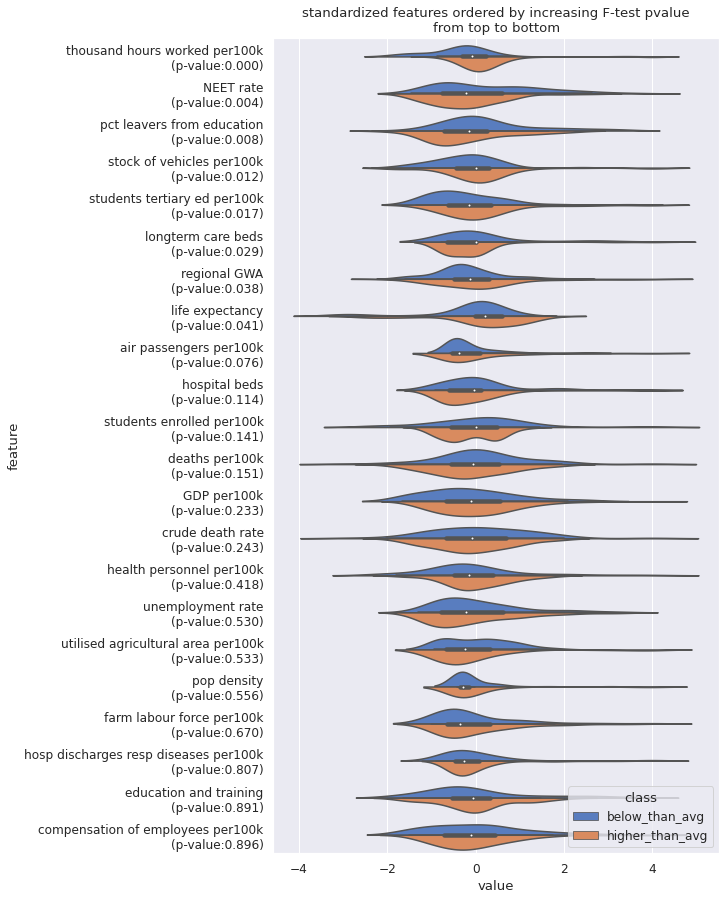

In [40]:
get_side_by_side_plots(dm, 
                       './from_2020-08-20_to_2021-02-20__cumulativepositive__nclust_2_with_ML/per100kdataset_from_2020-08-20_to_2021-02-20.csv',
                      dest_dir_path='./violin_plots_side_by_side')

## visualize statistics of the dataset

/home/xrh1/Desktop/covidlombardy/analysis_lib/utils.py:213: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  plt.figure(figsize=(10,5) )


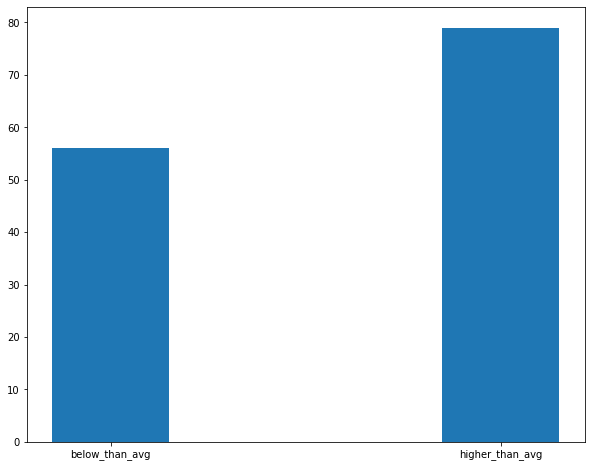

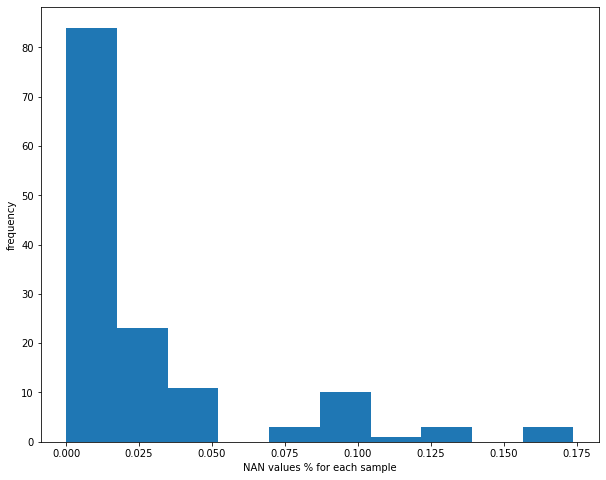

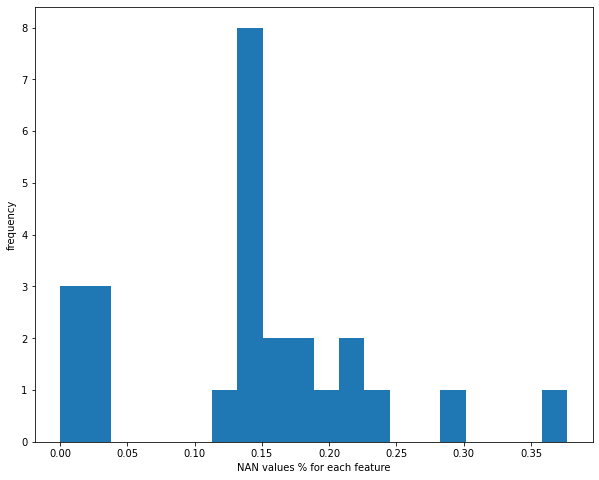

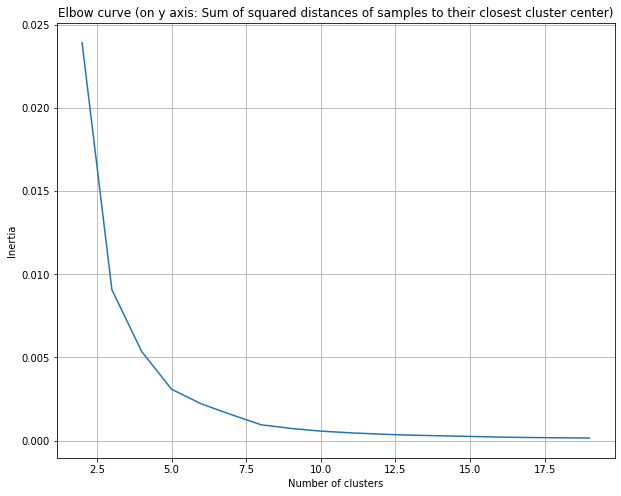

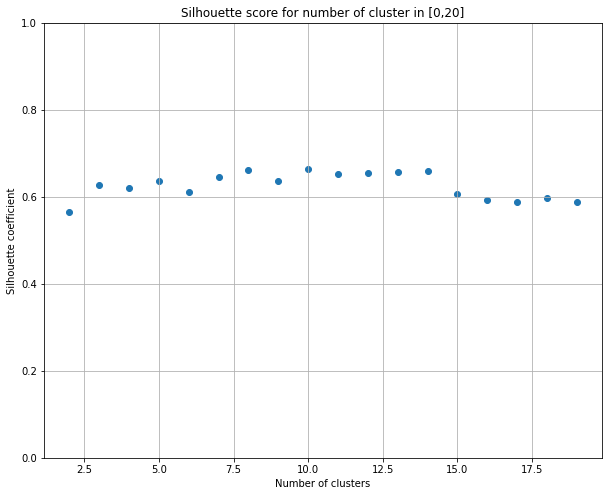

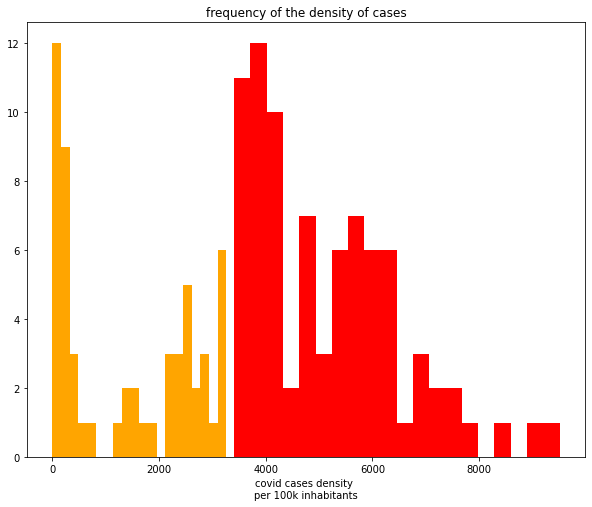

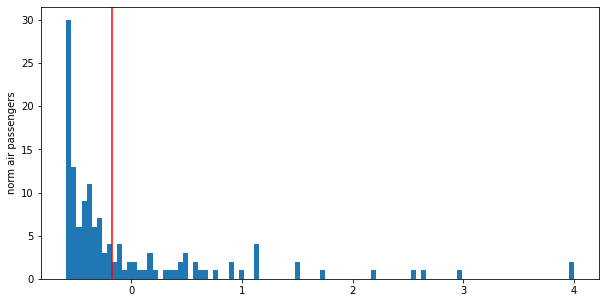

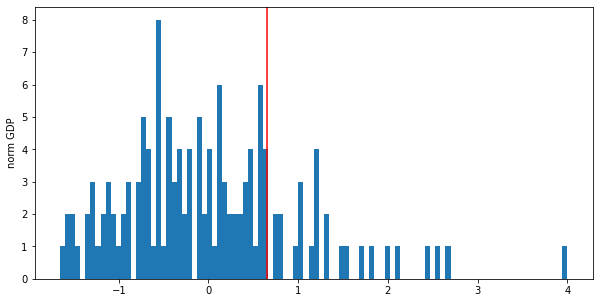

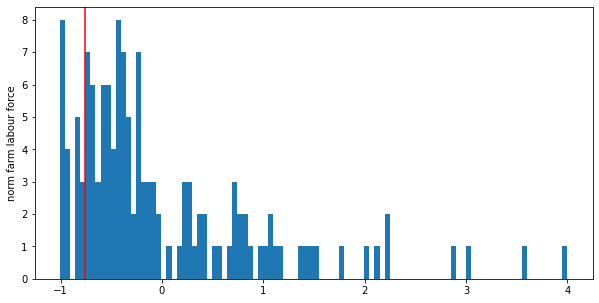

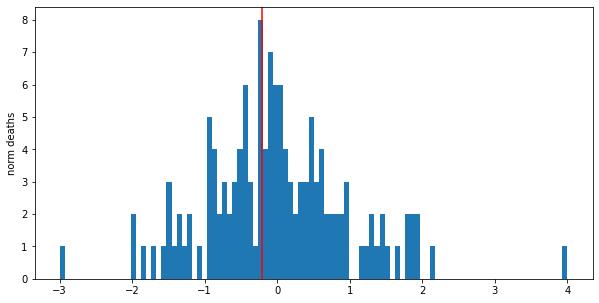

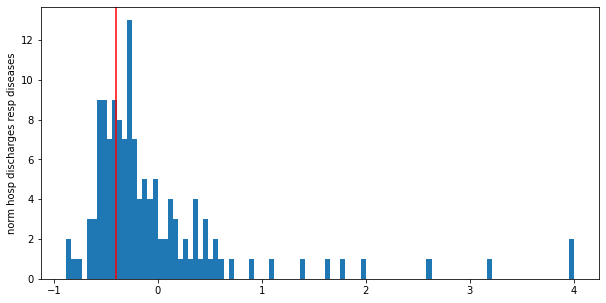

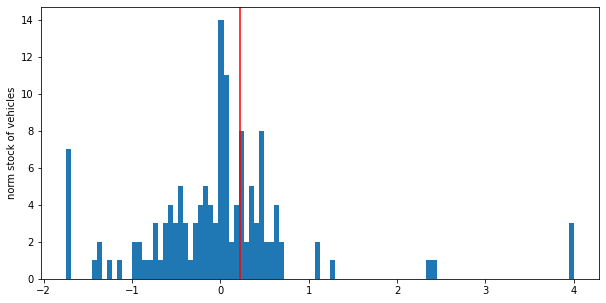

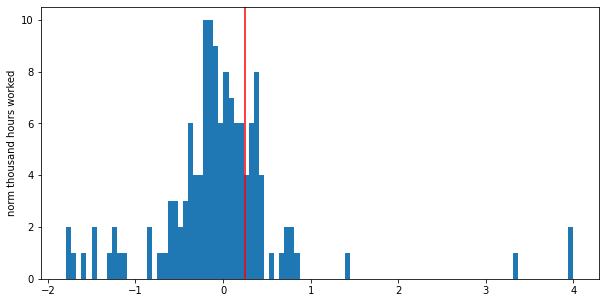

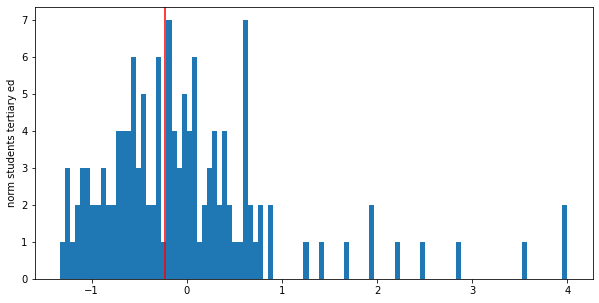

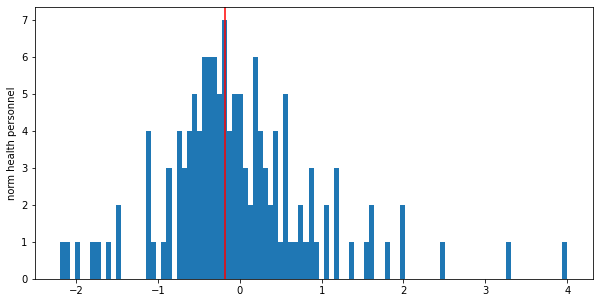

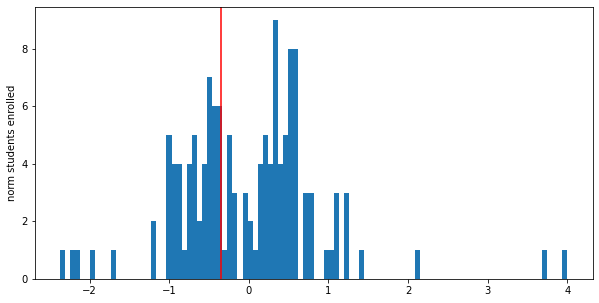

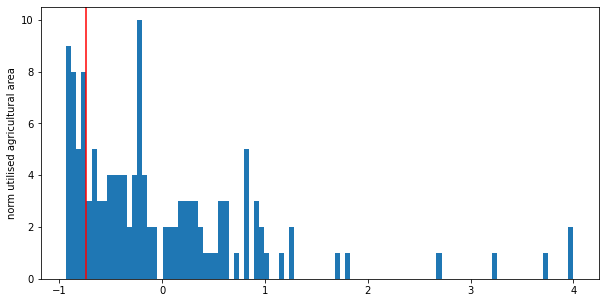

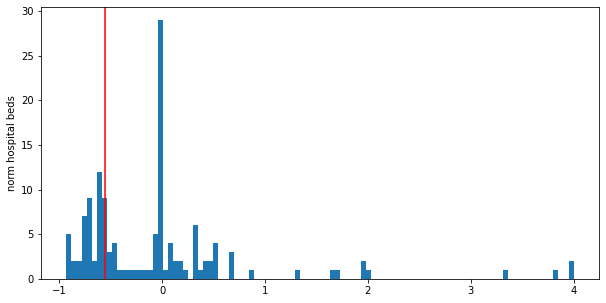

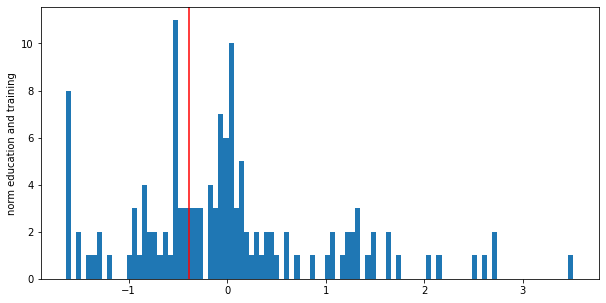

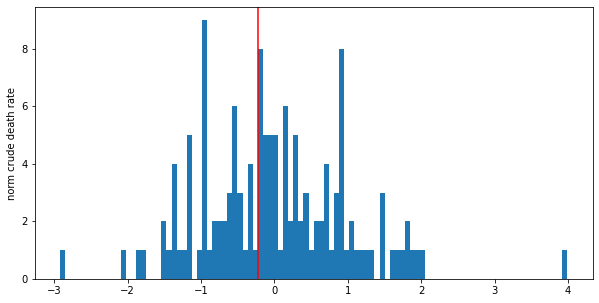

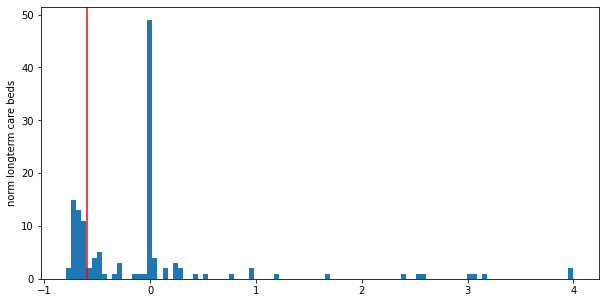

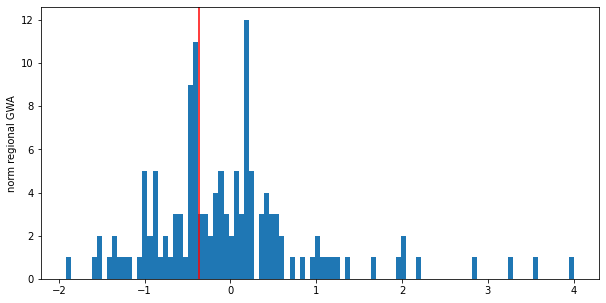

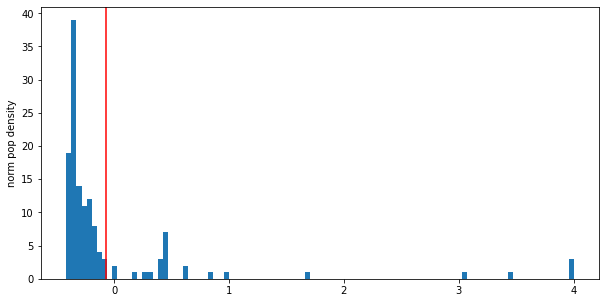

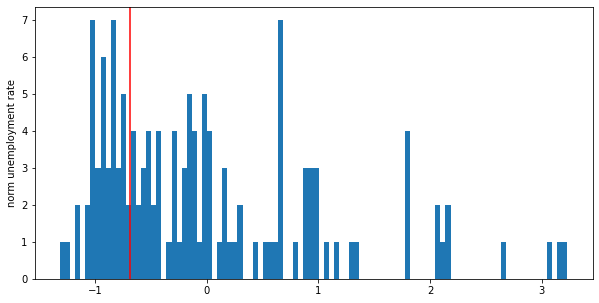

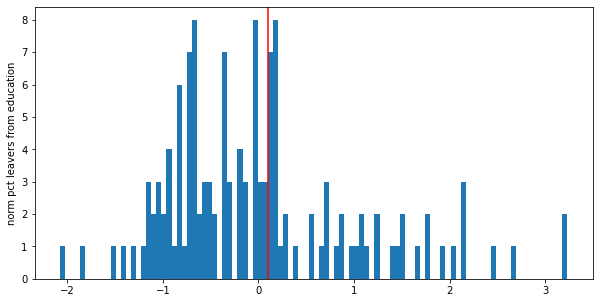

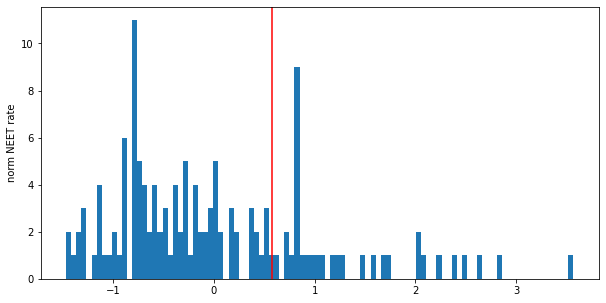

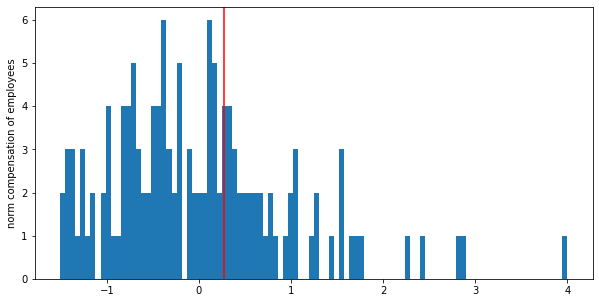

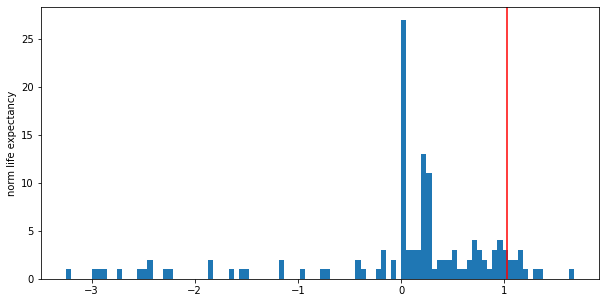

In [5]:
figsize=(10,8)
plot_class_distribution(dm,figsize)
plot_sample_nans(dm,figsize)
plot_feature_nans(dm,figsize)
plot_clustering_quality(dm,figsize)
plot_clustering_subdivision(dm,figsize)
plot_lombardy_vs_all(dm,figsize)


In [6]:
logger_path = os.path.join(dm.get_experiment_identifier(), "results")
logger = StatsLogger(logger_path)
logger.log_model_statistics(dm, 
                        None,
                         P_VAL_THRESHOLD=0.05,
                         N_RUNS=20,
                            k_smote = 6,)

saved violin plots to from_2020-08-20_to_2021-02-20__cumulativepositive__nclust_2_with_ML/results/violinplots
saved violin plots side by side to from_2020-08-20_to_2021-02-20__cumulativepositive__nclust_2_with_ML/results/violinplots_sidebyside


[0108/014516.408736:WARNING:vaapi_wrapper.cc(586)] VAAPI video acceleration not available for swiftshader
[0108/014516.412995:ERROR:gpu_init.cc(453)] Passthrough is not supported, GL is swiftshader, ANGLE is 


saved fscores to from_2020-08-20_to_2021-02-20__cumulativepositive__nclust_2_with_ML/results/fscores


[0108/014516.684929:INFO:headless_shell.cc(653)] Written to file /tmp/tmph5udn307/temp.png.


## Definition of the  hyperparameter search  pipeline

In [7]:
import itertools 
from sklearn.utils.class_weight import compute_class_weight


balanced_weight_dict = dict()
for class_name, class_weight in zip(np.unique(y), compute_class_weight('balanced', np.unique(y),y)):
    balanced_weight_dict[class_name] = round(class_weight, 2)    
    
class_weight_selection = [{'higher_than_avg':h_w, 'below_than_avg':l_w} \
                                             for h_w, l_w in itertools.product([1,2,3] , [0.5,1])
                                             ]
class_weight_selection.append(balanced_weight_dict)

svm_param_grid = {'model__kernel':['linear'], 'model__C':[ 0.1, 0.5, 1., 5., 10., 20, 50.],
                 'model__class_weight': class_weight_selection
                 }
rf_param_grid = {

    'model__criterion':['gini'],
 'model__max_features': ['sqrt'],

    'model__n_estimators': [100,400 ],
'model__max_depth': [4, 8, 16, 24, None],
    'model__min_samples_leaf': [1, 3, 5],
    'model__class_weight': class_weight_selection           
    }
log_reg_param_grid = {
    'model__penalty':['l1','l2'],
     'model__C':[ 0.1, 0.5, 1., 5., 10., 20, 50.],
    'model__class_weight': class_weight_selection,
    'model__solver':['liblinear'],
    'model__max_iter':[1000],
    
}

model_names = ["random_forest", "svm", "logistic_regression"]
models_list = [RandomForestClassifier(), 
               SVC(),
               LogisticRegression()]
params_list = [rf_param_grid, svm_param_grid, log_reg_param_grid]




/home/xrh1/.local/lib/python3.8/site-packages/sklearn/utils/validation.py:70: FutureWarning: Pass classes=['below_than_avg' 'higher_than_avg'], y=NUTS
AT11    higher_than_avg
AT12    higher_than_avg
AT13    higher_than_avg
AT21    higher_than_avg
AT22    higher_than_avg
             ...       
RO42    higher_than_avg
SK01    higher_than_avg
SK02    higher_than_avg
SK03    higher_than_avg
SK04    higher_than_avg
Name: covid_severity, Length: 135, dtype: object as keyword args. From version 1.0 (renaming of 0.25) passing these as positional arguments will result in an error
  warnings.warn(f"Pass {args_msg} as keyword args. From version "


# Run the hyperparameter search


In [8]:
results_list = []

curr_scorer = f1_macro
for model_name, model, param_grid in zip(model_names, models_list,params_list):
    

            
    pipeline = imb_pipeline.Pipeline( steps= [
                                              ('sampling', SMOTE(k_neighbors=k_smote)),
                                          ("model",model)    ])    
    outer_cv = StratifiedKFold(n_splits=10)
    inner_cv = LeaveOneOut()
    try:
        gs = GridSearchCV(pipeline, param_grid=param_grid, cv=inner_cv, 
                                          scoring=curr_scorer,
                                          n_jobs=-1)

        gs.fit(X_train_full, y_train_full)
        score = curr_scorer(gs, X_test, y_test)
        
        results_list.append({"model_name":model_name, 
                             "gs": gs, 
                             'test_score': score
                            })
    except Exception as err:
        print(err)
        

# Find and save the best models of each model class

In [9]:
best_models_dict = dict()
for model_dict in results_list:
    model_dict['model_name']
    best_models_dict[model_dict['model_name']] = model_dict['gs'].best_estimator_

serializable_model_dict = dict()
for model_dict in results_list:
    serializable_model_dict[model_dict['model_name']] = export_pipeline(model_dict['gs'].best_estimator_)


save_json(os.path.join(dm.get_experiment_identifier(), 'best_models_dict.json'), 
          serializable_model_dict)

best_models_dict

{'random_forest': Pipeline(steps=[('sampling', SMOTE(k_neighbors=6)),
                 ('model',
                  RandomForestClassifier(class_weight={'below_than_avg': 0.5,
                                                       'higher_than_avg': 1},
                                         max_depth=8, max_features='sqrt',
                                         min_samples_leaf=3))]),
 'svm': Pipeline(steps=[('sampling', SMOTE(k_neighbors=6)),
                 ('model',
                  SVC(C=0.5,
                      class_weight={'below_than_avg': 1, 'higher_than_avg': 1},
                      kernel='linear'))]),
 'logistic_regression': Pipeline(steps=[('sampling', SMOTE(k_neighbors=6)),
                 ('model',
                  LogisticRegression(C=5.0,
                                     class_weight={'below_than_avg': 0.5,
                                                   'higher_than_avg': 3},
                                     max_iter=1000, penalty='l1',
       

# Plot hyper parameter search metrics

In [10]:
parse_gridsearch_to_csv(results_list, 'hyperparam_search_models', dm.get_experiment_identifier())

### create paths to store the images

In [11]:
hp_search_path = os.path.join( dm.get_experiment_identifier(), 'hyperparam_search_models' )

hp_search_dict = dict()
for model_gs_filename in os.listdir(hp_search_path):
    
    curr_path = os.path.join(hp_search_path, model_gs_filename)
    model_name = model_gs_filename.rsplit('.')[0]
    hp_search_dict[model_name] = pd.read_csv(curr_path, index_col=0)
    
hp_search_plot_path = os.path.join( dm.get_experiment_identifier(), 'hyperparam_search_heatmaps' )
os.makedirs(hp_search_plot_path, exist_ok=True)

model_to_path_dict = { model_name : os.path.join(hp_search_plot_path, model_name) for model_name in model_names}
_ = [os.makedirs(model_path, exist_ok=True) for model_name, model_path in model_to_path_dict.items()]


## Heatmaps of the hyper parameter combinations 
**Darker colors represent a better combination**

###  logistic regression

available parameter names:
 ['C', 'class weight', 'max iter', 'penalty', 'solver']
available parameter names:
 ['C', 'class weight', 'max iter', 'penalty', 'solver']
available parameter names:
 ['C', 'class weight', 'max iter', 'penalty', 'solver']


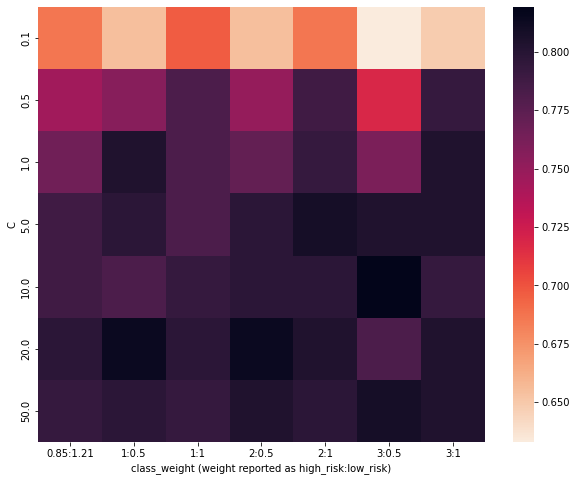

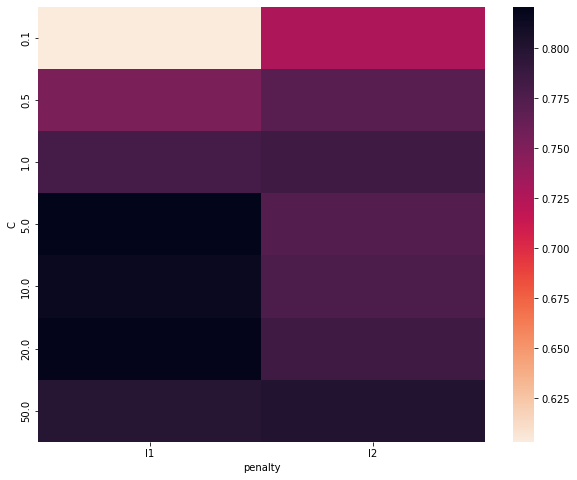

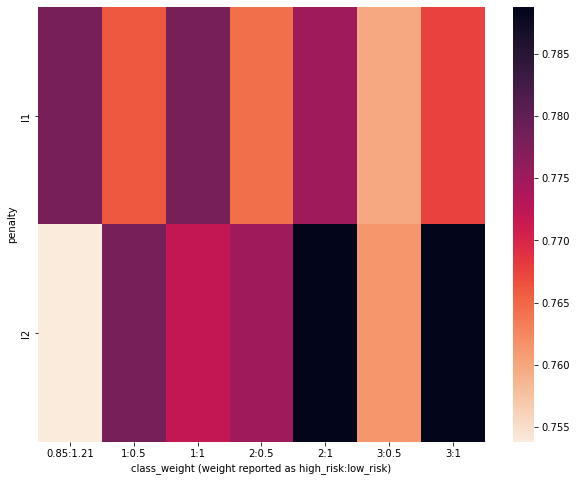

In [12]:

model_name = 'logistic_regression'
model_dirpath = model_to_path_dict[model_name]
hp_df = hp_search_dict[model_name]
plot_hpsearch_heatmap(hp_df, 'C', 'class weight', model_dirpath)
plot_hpsearch_heatmap(hp_df, 'C', 'penalty', model_dirpath)
plot_hpsearch_heatmap(hp_df, 'penalty', 'class weight', model_dirpath)

### svm

available parameter names:
 ['C', 'class weight', 'kernel']


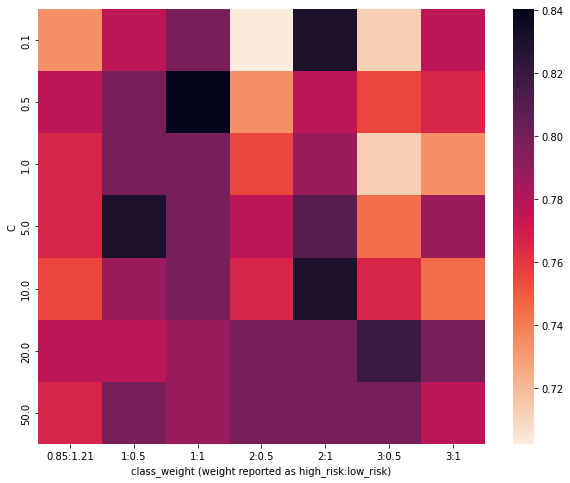

In [13]:
model_name = 'svm'
model_dirpath = model_to_path_dict[model_name]
hp_df = hp_search_dict[model_name]
plot_hpsearch_heatmap(hp_df, 'C', 'class weight', model_dirpath)

### random forest

available parameter names:
 ['class weight', 'criterion', 'max depth', 'max features', 'min samples leaf', 'n estimators']
available parameter names:
 ['class weight', 'criterion', 'max depth', 'max features', 'min samples leaf', 'n estimators']
available parameter names:
 ['class weight', 'criterion', 'max depth', 'max features', 'min samples leaf', 'n estimators']
available parameter names:
 ['class weight', 'criterion', 'max depth', 'max features', 'min samples leaf', 'n estimators']
available parameter names:
 ['class weight', 'criterion', 'max depth', 'max features', 'min samples leaf', 'n estimators']
available parameter names:
 ['class weight', 'criterion', 'max depth', 'max features', 'min samples leaf', 'n estimators']


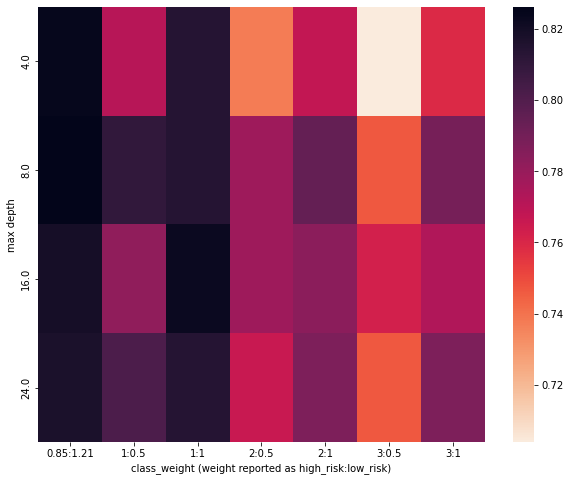

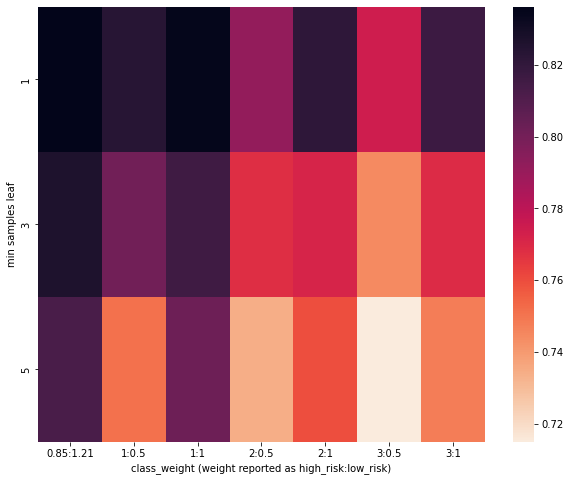

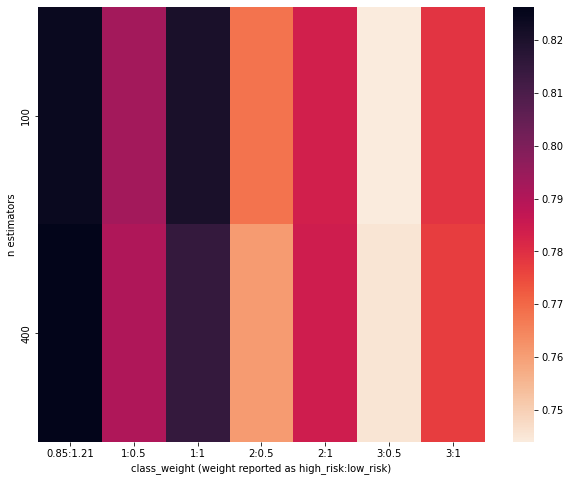

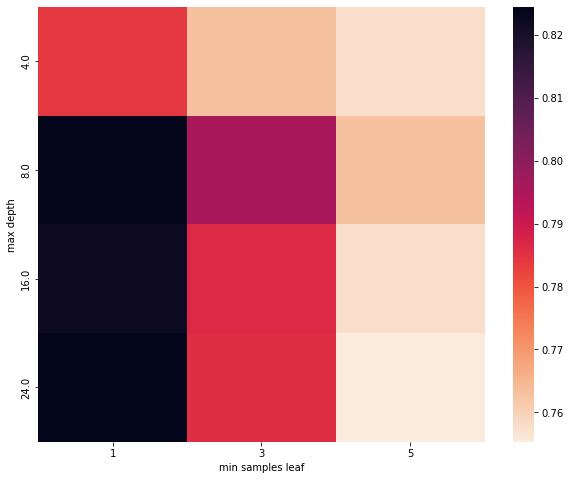

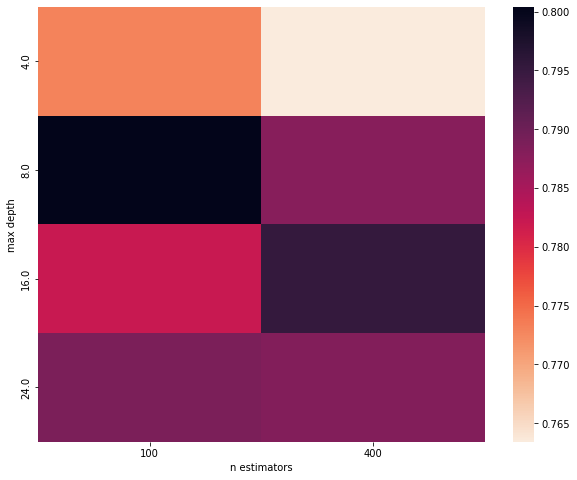

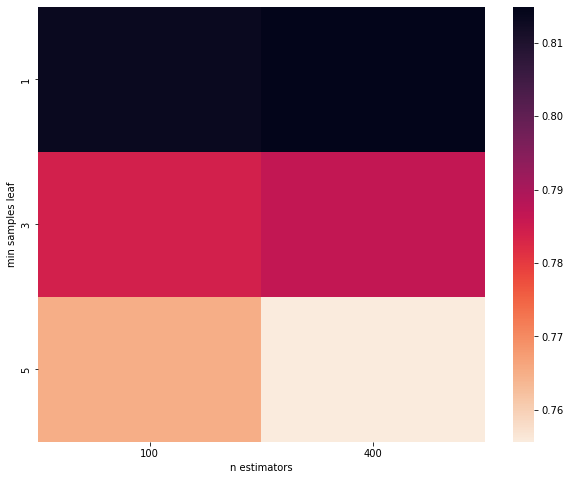

In [14]:
model_name = 'random_forest'
model_dirpath = model_to_path_dict[model_name]
hp_df = hp_search_dict[model_name]
plot_hpsearch_heatmap(hp_df, 'max depth', 'class weight', model_dirpath)
plot_hpsearch_heatmap(hp_df, 'min samples leaf', 'class weight', model_dirpath)
plot_hpsearch_heatmap(hp_df, 'n estimators', 'class weight', model_dirpath)

plot_hpsearch_heatmap(hp_df,'max depth', 'min samples leaf', model_dirpath)
plot_hpsearch_heatmap(hp_df, 'max depth', 'n estimators', model_dirpath)
plot_hpsearch_heatmap(hp_df, 'min samples leaf', 'n estimators', model_dirpath)

# Train and Validation of the optimized models

random_forest
random_forest
	f1_macro: 0.756700191849311	
recall: 0.8607594936708861	
precision: 0.7727272727272727

svm
svm
	f1_macro: 0.8409537166900422	
recall: 0.8481012658227848	
precision: 0.881578947368421

logistic_regression
logistic_regression
	f1_macro: 0.8180912765832796	
recall: 0.9240506329113924	
precision: 0.8111111111111111



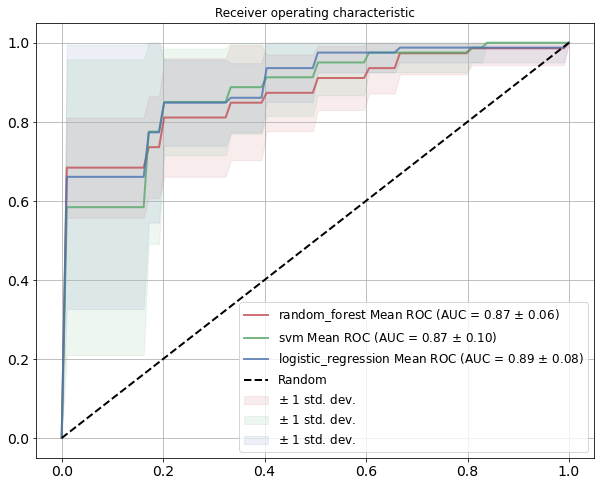

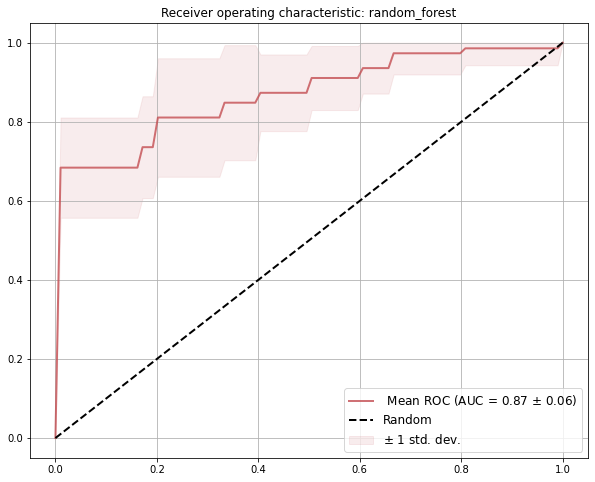

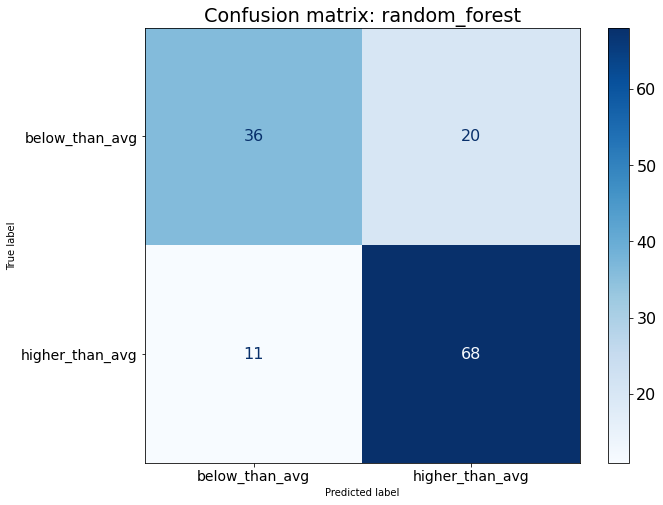

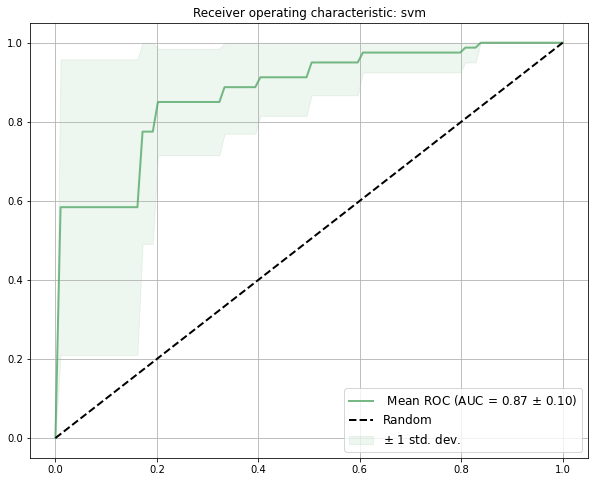

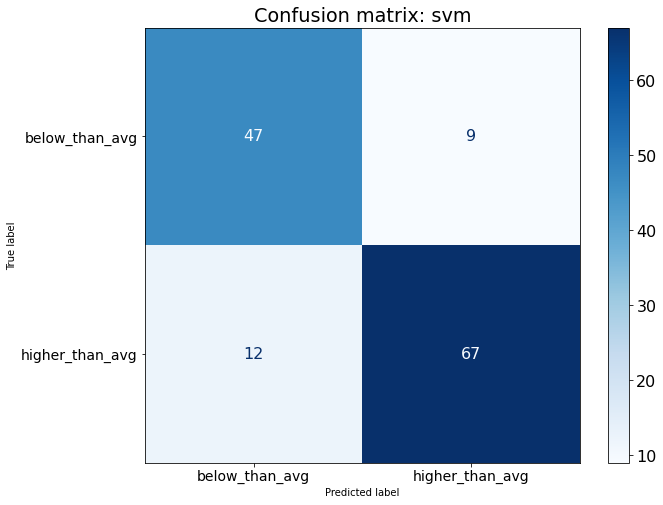

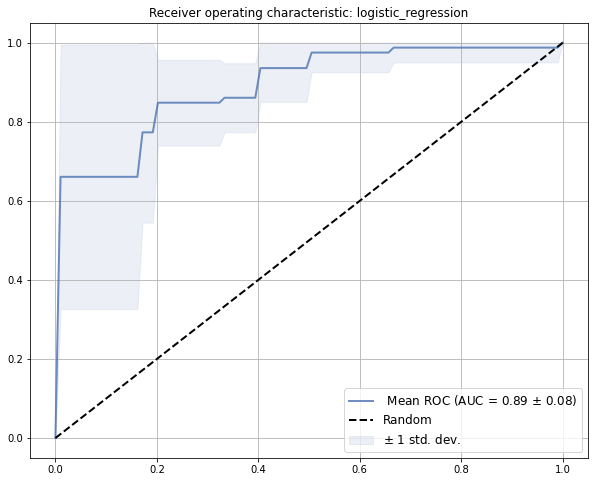

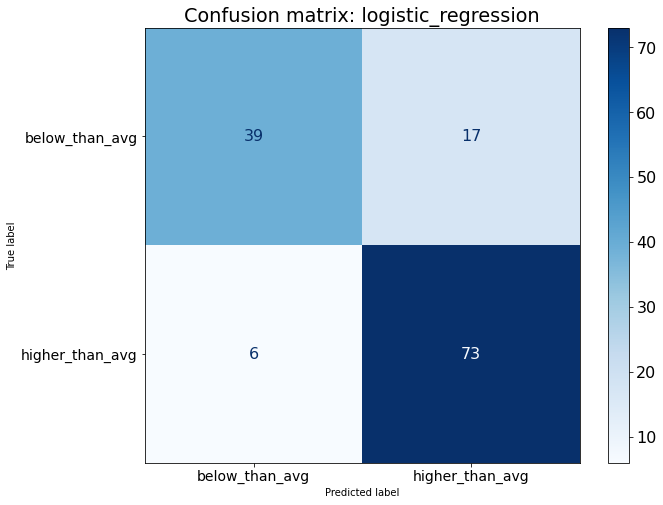

In [33]:
from sklearn import metrics


scoring = {
    'f1_macro':f1_macro,
           "recall": recall,
          'precision': precision,
          
          'misclf_err':misclf_error
            }
bestmodels_cv_results = []

sns.reset_orig()

model_colors = ['r', 'g', 'b']

fig_ALL_ROCS, ax_ALL_ROCS = plt.subplots(figsize=(10,8))
ax_ALL_ROCS.tick_params(axis='both', labelsize=14)
ax_ALL_ROCS.title.set_fontsize(20)
for item_idx, (model_name, model) in enumerate(best_models_dict.items()) :
    fig, ax = plt.subplots(figsize=(10,8))
    tprs=[]
    aucs=[]
    mean_fpr = np.linspace(0, 1, 100)
    bestmodels_confmatr_list = []
    predlist = []
    print(model_name)
    kfolds = StratifiedKFold(n_splits=10, shuffle=True)
    for fold, (train_index, test_index) in enumerate(kfolds.split(X, y)):

                X_train,y_train = X.iloc[train_index], y.iloc[train_index]
                X_test,y_test = X.iloc[test_index], y.iloc[test_index] 

                pipeline =  sklearn.base.clone(model)
                
                pipeline['model'].probability=True

                pipeline.fit(X_train, y_train)   
                pos_label_idx = np.argmax(pipeline.classes_ == 'higher_than_avg')
                score = curr_scorer(pipeline, X_test, y_test)
                
                preds = pipeline.predict(X_test)
                predlist.append((y_test.values, preds))

                
                
                fpr, tpr, thresholds = metrics.roc_curve(y_test, 
                                                                         pipeline.predict_proba(X_test)[:,pos_label_idx],
                                                                        pos_label='higher_than_avg')
                auc = metrics.roc_auc_score(y_test,pipeline.predict_proba(X_test)[:,pos_label_idx]  )
                
                interp_tpr = np.interp(mean_fpr, fpr, tpr)
                interp_tpr[0] = 0.0
                tprs.append(interp_tpr)
                aucs.append(auc) 
                
                model_fold_dict = {"model_name":model_name, 
                                          "gs": pipeline,  
                                          "fold_idx":fold}
                
                for scorer_name, scorer_fun in scoring.items():
                    score = scorer_fun(pipeline, X_test, y_test)
                    model_fold_dict['test_' + scorer_name] = score
                    
                bestmodels_cv_results.append(model_fold_dict)
    y_true = np.vstack( [y_true.reshape(-1,1) for y_true, y_pred in predlist])
    y_preds = np.vstack( [y_pred.reshape(-1,1) for y_true, y_pred in predlist])
    
    f1 = f1_score(y_true,y_preds,  average='macro')
    rec = recall_score(y_true,y_preds,  pos_label="higher_than_avg")
    prec = precision_score(y_true,y_preds,  pos_label="higher_than_avg")
    print(f'{model_name}\n\tf1_macro: {f1}\t\nrecall: {rec}\t\nprecision: {prec}\n')
    
    
    roc_dir_path = os.path.join(dm.get_experiment_identifier(), 'roc_curves')
    cm_dir_path = os.path.join(dm.get_experiment_identifier(), 'confusion_matrices')
    if not os.path.exists(roc_dir_path):
        os.makedirs(roc_dir_path)
    if not os.path.exists(cm_dir_path):
        os.makedirs(cm_dir_path)
    roc_file_path = os.path.join(roc_dir_path, model_name + '.png')
    cm_file_path = os.path.join(cm_dir_path, model_name + '.png')
    ax.grid()
    plot_curve(tprs,aucs, mean_fpr, ax, 
               mean_curve_color=model_colors[item_idx], title=model_name)    
    ax.plot([0, 1], [0,1], color='black', linestyle='--', linewidth=2, label='Random')
    ax.legend(loc="lower right",prop={'size': 12})
    fig.savefig(roc_file_path, bbox='tight')
    
    
    
    ax_ALL_ROCS.grid()
    plot_curve(tprs,aucs, mean_fpr, ax_ALL_ROCS, 
               mean_curve_color=model_colors[item_idx], title=None, model_name=model_name)
    
    #'''
    fig, ax = plt.subplots(figsize=(10,8))
    plt.rcParams.update({'font.size': 16})

    cm = confusion_matrix(np.vstack( [y_true.reshape(-1,1) for y_true, y_pred in predlist]), 
                     np.vstack( [y_pred.reshape(-1,1) for y_true, y_pred in predlist]),
                    labels=list(dm.clusterid_to_categorical_mapping.values() ))
    plt.title(f'Confusion matrix: {model_name}')
    ConfusionMatrixDisplay(cm,
                               display_labels=dm.clusterid_to_categorical_mapping.values())\
                                .plot(ax=ax,
                                     cmap=plt.cm.Blues)

    ax.tick_params(axis='both', labelsize=14)

    fig.savefig(cm_file_path, bbox='tight')
    sns.reset_orig()
    #'''
ax_ALL_ROCS.title.set_fontsize(12)
ax_ALL_ROCS.plot([0, 1], [0,1], color='black', linestyle='--', linewidth=2, label='Random')
ax_ALL_ROCS.legend(loc="lower right",prop={'size': 12})

all_rocs_file_path = os.path.join(roc_dir_path, 'all_rocs.png')  

fig_ALL_ROCS.savefig(all_rocs_file_path, bbox='tight')    


# Mean test score metrics 

In [32]:
bestmodels_cv_results
best_cv_dict_of_lists = {k: [dic[k] for dic in bestmodels_cv_results] for k in bestmodels_cv_results[0]}

best_cv_df = pd.DataFrame(best_cv_dict_of_lists)

best_cv_df.groupby('model_name').mean()
res_df = pd.DataFrame( )
#res_df['mean_test_score'] = best_cv_df.groupby('model_name').mean()['test_score']
#res_df['std_test_score'] = best_cv_df.groupby('model_name').std()['test_score']
for score_name, _ in scoring.items():
    res_df['mean_test_' + score_name] = best_cv_df.groupby('model_name').mean()['test_' + score_name]
    res_df['std_test_' + score_name] = best_cv_df.groupby('model_name').std()['test_' + score_name]
res_df

,mean_test_f1_macro,std_test_f1_macro,mean_test_recall,std_test_recall,mean_test_precision,std_test_precision,mean_test_misclf_err,std_test_misclf_err
model_name,,,,,,,,
logistic_regression,0.814,0.094,0.909,0.110,0.833,0.106,0.170,0.083
random_forest,0.783,0.112,0.836,0.145,0.827,0.109,0.206,0.108
svm,0.814,0.110,0.811,0.134,0.893,0.125,0.180,0.105


# Save the coefficients of the models trained in each fold in the notebook section:  

   ## Train and Validation of the optimized models  


In [17]:
save_interpretations(bestmodels_cv_results, dm, 'test_f1_macro')          

/home/xrh1/.local/lib/python3.8/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(
/home/xrh1/.local/lib/python3.8/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(
/home/xrh1/.local/lib/python3.8/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


## Test m-anova hypotesis

In [18]:
from statsmodels.multivariate.manova import MANOVA

man = MANOVA(X, sklearn.preprocessing.OrdinalEncoder().fit_transform(y.values.reshape(-1,1)))

man.mv_test().summary()

<class 'statsmodels.iolib.summary2.Summary'>
"""
                  Multivariate linear model
==============================================================
                                                              
--------------------------------------------------------------
           x0           Value   Num DF  Den DF  F Value Pr > F
--------------------------------------------------------------
          Wilks' lambda 0.7402 22.0000 113.0000  1.8030 0.0244
         Pillai's trace 0.2598 22.0000 113.0000  1.8030 0.0244
 Hotelling-Lawley trace 0.3510 22.0000 113.0000  1.8030 0.0244
    Roy's greatest root 0.3510 22.0000 113.0000  1.8030 0.0244
==============================================================

"""